<a href="https://colab.research.google.com/github/henrycgbaker/nlp_research_note/blob/main/research_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install datasets fasttext evaluate
import os
import subprocess
import time
import kagglehub
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
import spacy
import spacy.cli
import fasttext.util as fasttext_util
import fasttext
from collections import Counter
import collections
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
import warnings
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

/Users/henrybaker/miniconda3/envs/nlp_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load helper functions & scripts ----------------------------------------------
'''
sys.path.append('./aux_scripts')
from  misinfo_tokenizer import (get_trained_tokenizer,
                                batch_tokenize,
                                #vocab_mapping,
                                custom_analyzer
                                )
from data_loader_helpers import (#Collator,
                                 embedding_mapping_fasttext
                                 )
'''

"\nsys.path.append('./aux_scripts')\nfrom  misinfo_tokenizer import (get_trained_tokenizer,\n                                batch_tokenize,\n                                #vocab_mapping,\n                                custom_analyzer\n                                )\nfrom data_loader_helpers import (#Collator,\n                                 embedding_mapping_fasttext\n                                 )\n"

In [3]:
# DATA
DATA_DIR = "./data"
TRAIN_DATA_FILE = "./data/twitter_train_data.csv"
TEST_DATA_FILE = "./data/twitter_test_data.csv"

def check_and_load_data():
    if os.path.exists(TRAIN_DATA_FILE) and os.path.exists(TEST_DATA_FILE):
        print("Loading data")
        train_df = pd.read_csv(TRAIN_DATA_FILE)
        test_df = pd.read_csv(TEST_DATA_FILE)
        return train_df, test_df
    else:
        os.makedirs(DATA_DIR, exist_ok=True)
        print("Calling data processing script")
        
        # call pynb script
        subprocess.run(['jupyter', 'nbconvert', '--execute', '--to', 'notebook', '--inplace', '_1_data_processing.ipynb'])
        
        # ensure the notebook script finishes execution
        time.sleep(5) 
        
        # recursively call to check for the files again
        return check_and_load_data()

train_df, test_df = check_and_load_data()


Loading data


---
# Import `Model Development Data`
See `data_processing script`

In [4]:
# download spacy model for tokenization ----------------------------------------
cache_path = './cache/'
os.makedirs(cache_path, exist_ok=True)
os.environ['SPACY_DATA'] = cache_path
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.7 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
# DEFINE TOKENIZATION FLOW =====================================================================

nlp = spacy.load("en_core_web_sm", 
                 disable=["tok2vec", "tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])

def custom_tokenizer(text):
    tokenized_text = nlp(text)
    return [tok.text for tok in tokenized_text]

def custom_analyzer(text, trained_tokenizer):
    """
    Uses the custom_tokenizer, then replaces out-of-vocabulary tokens with <unk>.
    """
    tokens = custom_tokenizer(text)
    vocab = trained_tokenizer.vocabulary_
    return [token if token in vocab else "<unk>" for token in tokens]

def get_trained_tokenizer(text_series, rnn_tokenizer_file=None, min_df=3):
    """
    1) Checks if a previously fitted tokenizer exists in tokenizer_file.
    2) If not, create a new CountVectorizer, fit it on 'text_series'.
    3) Save the fitted tokenizer if tokenizer_file is provided.
    4) Return the tokenizer.
    """
    # ensure dir exists, but check if it's a file first
    if rnn_tokenizer_file:
        tokenizer_dir = os.path.dirname(rnn_tokenizer_file)
        if os.path.exists(tokenizer_dir):
            if os.path.isfile(tokenizer_dir):
                raise FileExistsError(f"The path '{tokenizer_dir}' exists but is a file, not a directory.")
        else:
            os.makedirs(tokenizer_dir, exist_ok=True)

    if rnn_tokenizer_file and os.path.exists(rnn_tokenizer_file):
        print(f"Tokenizer file '{rnn_tokenizer_file}' found. Loading it...")
        with open(rnn_tokenizer_file, 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        print("No pre-fitted tokenizer found or no file specified. Creating a new one...")
        tokenizer = CountVectorizer(
            analyzer="word",
            tokenizer=custom_tokenizer, 
            lowercase=False,
            min_df=min_df
        )
        tokenizer.fit(text_series)
        
        if rnn_tokenizer_file:
            print(f"Saving fitted tokenizer to '{rnn_tokenizer_file}'...")
            with open(rnn_tokenizer_file, 'wb') as f:
                pickle.dump(tokenizer, f)

    return tokenizer

def batch_tokenize(text_series, batch_size, analyzer_func):
    """
    Tokenizes a Pandas Series of text in batches to avoid memory issues.
    """
    tokenized_result = []
    total = len(text_series)
    num_batches = (total // batch_size) + (1 if total % batch_size != 0 else 0)
    
    for batch_idx in range(0, total, batch_size):
        
        if (batch_idx // batch_size + 1) % 200 == 0 or (batch_idx + batch_size >= total):
            print(f'Tokenizing batch {batch_idx // batch_size + 1} of {num_batches}...')
        
        batch_texts = text_series[batch_idx : batch_idx + batch_size]
        for text in batch_texts:
            tokenized_result.append(analyzer_func(text))
    
    return tokenized_result

# TOKENIZATION ==========================================================================
TOKENIZER_DIR = './cache' 
RNN_TOKENIZER_PKL_PATH = os.path.join(TOKENIZER_DIR, 'rnn_tokenizer_file.pkl')  
train_tokenised_file = os.path.join(TOKENIZER_DIR, 'misinfo_train_tokenised.pkl')
test_tokenised_file = os.path.join(TOKENIZER_DIR, 'misinfo_test_tokenised.pkl')

if os.path.exists(train_tokenised_file) and os.path.exists(test_tokenised_file):
    print("Tokenized text pkl files found: loading data...")
    with open(train_tokenised_file, 'rb') as f:
        misinfo_train_tokenised = pickle.load(f)
    with open(test_tokenised_file, 'rb') as f:
        misinfo_test_tokenised = pickle.load(f)

else:
    print("Pickle files not found. Running tokenization...")

    # 1) train tokenizer
    misinfo_tokenizer = get_trained_tokenizer(
        train_df["text"],
        rnn_tokenizer_file=RNN_TOKENIZER_PKL_PATH,  # Path fixed
        min_df=3
    )

    # build analyzer from tokenizer
    misinfo_tokenizer_analyzer = misinfo_tokenizer.build_analyzer()

    # 2) Tokenize train data in batches using built analyzer (trained on train set)
    print("Tokenizing Train Data in Batches...")
    misinfo_train_tokenised = batch_tokenize(
        train_df["text"],
        32,
        misinfo_tokenizer_analyzer
    )
    
    # 3) Tokenize test data in batches using custom_analyzer (which replaces OOV tokens with <unk>)
    print("Tokenizing Test Data in Batches...")
    misinfo_test_tokenised = batch_tokenize(
        test_df["text"],
        32,
        lambda text: custom_analyzer(text, trained_tokenizer=misinfo_tokenizer)
    )
    os.makedirs(TOKENIZER_DIR, exist_ok=True) 
    
    with open(train_tokenised_file, 'wb') as f:
        pickle.dump(misinfo_train_tokenised, f)
    
    with open(test_tokenised_file, 'wb') as f:
        pickle.dump(misinfo_test_tokenised, f)

print("Train inputs tokenised:", len(misinfo_train_tokenised))
print("Test inputs tokenised:", len(misinfo_test_tokenised))


Pickle files not found. Running tokenization...
No pre-fitted tokenizer found or no file specified. Creating a new one...
Saving fitted tokenizer to './cache/rnn_tokenizer_file.pkl'...
Tokenizing Train Data in Batches...
Tokenizing batch 200 of 238...
Tokenizing batch 238 of 238...
Tokenizing Test Data in Batches...
Tokenizing batch 60 of 60...
Train inputs tokenised: 7598
Test inputs tokenised: 1900


Calculating token distributions for training set...
Total unique tokens in train set: 77215
Plotting token distribution...


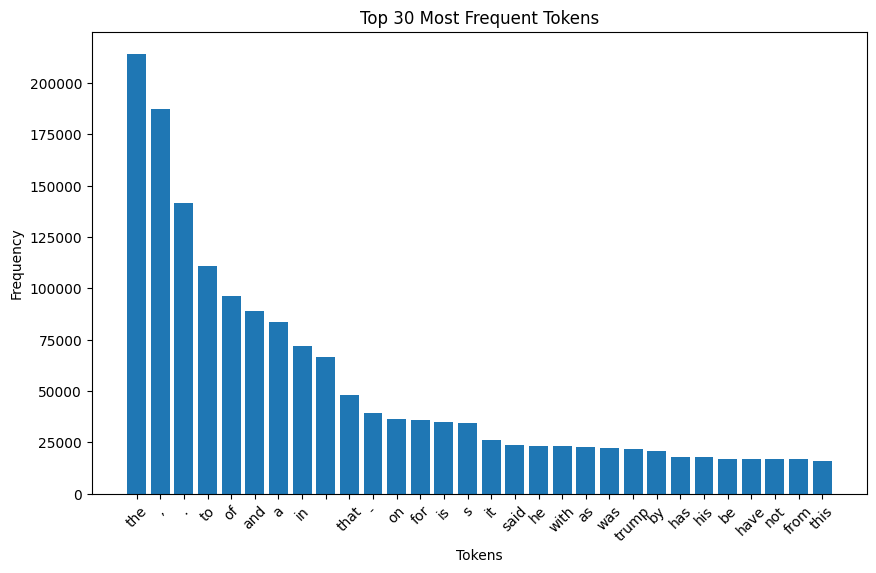

Plotting token distribution...


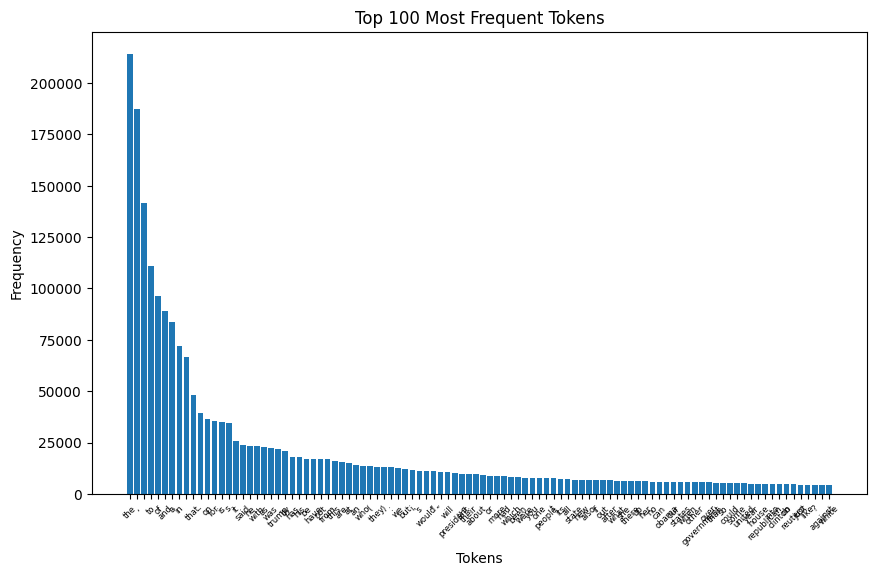

In [6]:
def get_token_distribution(tokenized_data):
    """
    Calculate the distribution of tokens from a list of tokenized sentences.
    """
    all_tokens = [token for tokens in tokenized_data for token in tokens]
    token_counts = collections.Counter(all_tokens)
    return token_counts

def plot_token_distribution(token_counts, top_n=30, fontsize=10):
    """
    Plot the distribution of the top N most frequent tokens.
    """
    most_common = token_counts.most_common(top_n)
    tokens, counts = zip(*most_common)
    
    plt.figure(figsize=(10, 6))
    plt.bar(tokens, counts)
    plt.xlabel("Tokens")
    plt.ylabel("Frequency")
    plt.title(f"Top {top_n} Most Frequent Tokens")
    plt.xticks(rotation=45, fontsize=fontsize) 
    plt.show()

print("Calculating token distributions for training set...")
train_token_counts = get_token_distribution(misinfo_train_tokenised)
print(f"Total unique tokens in train set: {len(train_token_counts)}")

print("Plotting token distribution...")
plot_token_distribution(train_token_counts, top_n=30)

print("Plotting token distribution...")
plot_token_distribution(train_token_counts, top_n=100, fontsize=6)

In [7]:
# STEP 1: INPUT PIPELINE ================================================================

# vocabulary indexing -------------------------------------------------------------------
def vocab_mapping(tokenized_text):
    token_counts = Counter()
    for text in tokenized_text:
        token_counts.update(text)
    special_tokens = ["<pad>", "<unk>"]
    vocab_tokens = special_tokens + [token for token, freq in token_counts.most_common()]
    vocab = {token: idx for idx, token in enumerate(vocab_tokens)}
    return vocab

vocab_idx = vocab_mapping(tokenized_text=misinfo_train_tokenised)

print(f"Vocab size: {len(vocab_idx)}")
print(f"Vocab first 20 idx printed: {list(vocab_idx.items())[:20]}")

with open("./cache/vocab_idx.pkl", "wb") as f:
    pickle.dump(vocab_idx, f)

Vocab size: 77217
Vocab example: [('<pad>', 0), ('<unk>', 1), ('the', 2), (',', 3), ('.', 4), ('to', 5), ('of', 6), ('and', 7), ('a', 8), ('in', 9), (' ', 10), ('that', 11), ('-', 12), ('on', 13), ('for', 14), ('is', 15), ('s', 16), ('it', 17), ('said', 18), ('he', 19)]


In [8]:
# create data loaders -------------------------------------------------------------------

def collate_fn(data, include_lengths=True):
    text_list, label_list, lengths = [], [], []
    for _text, _label in data:
        # integer encoding with truncation
        processed_text = torch.tensor([vocab_idx[token] for token in _text][:max_seq_length],
                                      dtype=torch.int64)
        text_list.append(processed_text)
        label_list.append(_label)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    # padding
    padded_text_list = nn.utils.rnn.pad_sequence(text_list,
                                                 batch_first=True,
                                                 padding_value=0)
    if include_lengths:
        return padded_text_list, label_list, lengths
    else:
        return padded_text_list, label_list

max_seq_length = 300 # too long for full RNNs
batch_size = 32

# standard dls with collate_fn
train_dl = DataLoader(dataset=list(zip(misinfo_train_tokenised,
                                         train_df["label"])),
                        batch_size=32, shuffle=True, 
                        collate_fn=lambda x: collate_fn(x, include_lengths=True))

test_dl = DataLoader(dataset=list(zip(misinfo_test_tokenised,
                                         test_df["label"])),
                        batch_size=32, shuffle=False, 
                        collate_fn=lambda x: collate_fn(x, include_lengths=True))

# dls w/o collate_fn for CNNs:
train_dl_cnn = DataLoader(dataset=list(zip(misinfo_train_tokenised,
                                         train_df["label"])),
                        batch_size=32, shuffle=True,
                        collate_fn=lambda x: collate_fn(x, include_lengths=False))

test_dl_cnn = DataLoader(dataset=list(zip(misinfo_test_tokenised,
                                         test_df["label"])),
                         batch_size=32, shuffle=True,
                        collate_fn=lambda x: collate_fn(x, include_lengths=False))

In [9]:
def inspect_token_lengths(dl):
    all_lengths = []
    for batch in dl:
        if len(batch) == 3:  # includes lengths (e.g., for train_dl, test_dl)
            _, _, lengths = batch
            all_lengths.extend(lengths.tolist())
        else:  # no lengths included (e.g., train_dl_cnn, test_dl_cnn)
            padded_text, _ = batch
            lengths = (padded_text != 0).sum(dim=1)  # count non-padding tokens
            all_lengths.extend(lengths.tolist())
    
    print(f"Total number of batches: {len(dl)}")
    print(f"Number of tokens per sequence (all): {all_lengths}")
    print(f"Max tokens in a sequence: {max(all_lengths)}")
    print(f"Min tokens in a sequence: {min(all_lengths)}")
    print(f"Average tokens per sequence: {sum(all_lengths) / len(all_lengths):.2f}")

print("Inspecting train_dl:")
inspect_token_lengths(train_dl)

print("\nInspecting test_dl:")
inspect_token_lengths(test_dl)

Inspecting train_dl:
Total number of batches: 238
Number of tokens per sequence (all): [300, 300, 37, 300, 300, 24, 300, 300, 129, 300, 300, 45, 300, 46, 300, 1, 300, 300, 300, 230, 300, 300, 59, 1, 300, 53, 1, 300, 170, 300, 30, 41, 300, 1, 300, 300, 1, 300, 300, 300, 73, 300, 300, 300, 300, 300, 1, 294, 300, 291, 300, 1, 117, 300, 300, 300, 300, 300, 300, 300, 118, 1, 300, 1, 300, 300, 300, 17, 300, 300, 119, 300, 300, 300, 37, 25, 54, 18, 1, 300, 1, 300, 24, 300, 300, 300, 300, 300, 300, 300, 300, 1, 53, 300, 300, 300, 300, 300, 27, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 236, 300, 54, 300, 23, 1, 300, 161, 300, 300, 31, 300, 300, 300, 300, 263, 300, 28, 1, 45, 300, 256, 300, 300, 300, 300, 300, 300, 186, 300, 300, 300, 28, 300, 69, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 1, 300, 50, 300, 300, 300, 300, 21, 19, 300, 300, 300, 53, 214, 97, 300, 36, 300, 300, 22, 300, 300, 54, 300, 300,

In [10]:
# EMBEDDING MAPPING =====================================================================

# download pretrained embeddings -----------------------------------------------

# for Colab
# !pip install datasets fasttext evaluate
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/Othercomputers/My MacBook Pro/Documents/repositories/nlp/nlp_research_note')
#ft_path = "./cc.en.300.bin"

ft_path = "./cache/cc.en.300.bin"

if not os.path.exists(ft_path):
    print("Model not found in cache. Downloading...")
    fasttext.util.download_model('en', if_exists='ignore')
    # Move the downloaded model to the cache folder
    os.makedirs(os.path.dirname(ft_path), exist_ok=True)
    os.rename("cc.en.300.bin", ft_path)
else:
    print("Model found in cache. Skipping download.")

ft = fasttext.load_model(ft_path)
print("Model loaded successfully.")

# map pretrained fasttext embeddings to vocabulary indices ------------------------------

EMBEDDINGS_FILE_PATH = "./cache/mapped_pretrained_embeddings.pkl"

def embedding_mapping_fasttext(vocabulary, pre_trained_embeddings):
    vocab_size = len(vocabulary)
    embedding_dim = pre_trained_embeddings.get_dimension()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for idx, word in enumerate(vocabulary):
        embedding_matrix[idx] = pre_trained_embeddings.get_word_vector(word)
    return embedding_matrix

if os.path.exists(EMBEDDINGS_FILE_PATH):
    with open(EMBEDDINGS_FILE_PATH, 'rb') as f:
        embedding_tensor = pickle.load(f)
    print(f"Emebddings pre-exists: loaded embeddings from {EMBEDDINGS_FILE_PATH}. Shape: {embedding_tensor.shape}")
else:
    print("Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices")

    mapped_pretrained_embeddings = embedding_mapping_fasttext(vocabulary=vocab_idx,
                                                              pre_trained_embeddings=ft)
    embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings)

    with open(EMBEDDINGS_FILE_PATH, 'wb') as f:
        pickle.dump(embedding_tensor, f)
    print(f"Saved embeddings to {EMBEDDINGS_FILE_PATH}. Shape: {embedding_tensor.shape}")
    
# this embedding tensor is then loaded into the first layer of the RNN-based models

Model found in cache. Skipping download.
Model loaded successfully.
Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices
Saved embeddings to ./cache/mapped_pretrained_embeddings.pkl. Shape: torch.Size([77217, 300])


In [11]:

if os.path.exists(EMBEDDINGS_FILE_PATH):
    with open(EMBEDDINGS_FILE_PATH, 'rb') as f:
        embedding_tensor = pickle.load(f)
    print(f"Loaded embeddings. Tensor shape: {embedding_tensor.shape}")


Loaded embeddings. Tensor shape: torch.Size([77217, 300])


In [12]:
def train(model, num_epochs, train_dl, test_dl, use_lengths=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    metrics = {
        "loss_train": [],
        "loss_test": [],
        "accuracy_train": [],
        "accuracy_test": [],
        "f1_train": [],
        "f1_test": []
    }

    for epoch in range(num_epochs):
        # training phase
        model.train()
        train_loss, train_correct = 0, 0
        all_train_preds, all_train_labels = [], []

        print(f"Epoch {epoch + 1}/{num_epochs} Training...")
        for batch in tqdm(train_dl, desc="Training", leave=False):
            if use_lengths:
                x_batch, y_batch, lengths = batch
                x_batch, y_batch, lengths = x_batch.to(device), y_batch.to(device), lengths.to(device)
                pred = model(x_batch, lengths)[:, 0]  # Include lengths for RNNs/LSTMs
            else:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)[:, 0]

            # compute loss
            loss = loss_fn(pred, y_batch.float())

            # backprop
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # metrics
            train_loss += loss.item() * y_batch.size(0)
            preds = (pred >= 0.5).float()
            train_correct += (preds == y_batch).float().sum().item()
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(y_batch.cpu().numpy())

        metrics["loss_train"].append(train_loss / len(train_dl.dataset))
        metrics["accuracy_train"].append(train_correct / len(train_dl.dataset))
        metrics["f1_train"].append(f1_score(all_train_labels, all_train_preds))

        # eval phase
        model.eval()
        test_loss, test_correct = 0, 0
        all_test_preds, all_test_labels = [], []
        print(f"Epoch {epoch + 1}/{num_epochs} Evaluating...")
        with torch.no_grad():
            for batch in tqdm(test_dl, desc="Evaluating", leave=False):
                if use_lengths:
                    x_batch, y_batch, lengths = batch
                    x_batch, y_batch, lengths = x_batch.to(device), y_batch.to(device), lengths.to(device)
                    pred = model(x_batch, lengths)[:, 0]
                else:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    pred = model(x_batch)[:, 0]

                # compute loss
                loss = loss_fn(pred, y_batch.float())

                # metrics
                test_loss += loss.item() * y_batch.size(0)
                preds = (pred >= 0.5).float()
                test_correct += (preds == y_batch).float().sum().item()
                all_test_preds.extend(preds.cpu().numpy())
                all_test_labels.extend(y_batch.cpu().numpy())

        metrics["loss_test"].append(test_loss / len(test_dl.dataset))
        metrics["accuracy_test"].append(test_correct / len(test_dl.dataset))
        metrics["f1_test"].append(f1_score(all_test_labels, all_test_preds))

        print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
        print(f"    Train - Loss: {metrics['loss_train'][-1]:.4f}, Accuracy: {metrics['accuracy_train'][-1]:.3f}, F1: {metrics['f1_train'][-1]:.3f}")
        print(f"    Test  - Loss: {metrics['loss_test'][-1]:.4f}, Accuracy: {metrics['accuracy_test'][-1]:.3f}, F1: {metrics['f1_test'][-1]:.3f}")

    return metrics

In [13]:
# STEP 2: MODEL BUILDING ================================================================
# see aux_scripts
sys.path.append('./aux_scripts')

In [14]:
# TRAINING ================================================================

# CNN

num_epochs = 10

from model_architectures import CNNTextClassifier
model_cnn = CNNTextClassifier(embedding_tensor=embedding_tensor)

if os.path.exists("./models/cnn_model.pth"):
    model_cnn = torch.load("./models/cnn_model.pth")
    print("Model loaded from disk.")
else:
    os.makedirs("./models/train_hist", exist_ok=True)
    print("Training the model...")
    num_epochs = 10
    hist_cnn = train(model_cnn, num_epochs, train_dl_cnn, test_dl_cnn, use_lengths=False)
    print("Training the model...")
    with open("./models/train_hist/cnn_hist.pkl", "wb") as f:
        pickle.dump(hist_cnn, f)
    torch.save(model_cnn, "./models/cnn_model.pth")

Training the model...
Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.4477, Accuracy: 0.748, F1: 0.654
    Test  - Loss: 0.2903, Accuracy: 0.858, F1: 0.830
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.2533, Accuracy: 0.868, F1: 0.845
    Test  - Loss: 0.2267, Accuracy: 0.884, F1: 0.867
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.2069, Accuracy: 0.883, F1: 0.865
    Test  - Loss: 0.2040, Accuracy: 0.889, F1: 0.875
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.1868, Accuracy: 0.885, F1: 0.869
    Test  - Loss: 0.2009, Accuracy: 0.885, F1: 0.872
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.1714, Accuracy: 0.891, F1: 0.875
    Test  - Loss: 0.1755, Accuracy: 0.885, F1: 0.868
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.1614, Accuracy: 0.912, F1: 0.902
    Test  - Loss: 0.1670, Accuracy: 0.888, F1: 0.874
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.1518, Accuracy: 0.901, F1: 0.888
    Test  - Loss: 0.1617, Accuracy: 0.889, F1: 0.877
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.1460, Accuracy: 0.923, F1: 0.915
    Test  - Loss: 0.1575, Accuracy: 0.953, F1: 0.951
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.1396, Accuracy: 0.934, F1: 0.928
    Test  - Loss: 0.1500, Accuracy: 0.953, F1: 0.951
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.1355, Accuracy: 0.944, F1: 0.940
    Test  - Loss: 0.1510, Accuracy: 0.955, F1: 0.954
Training the model...


In [15]:

# Vanilla RNN =====================================================================

from model_architectures import RNNTextClassifier

model_rnn = RNNTextClassifier(embedding_tensor=embedding_tensor)

if os.path.exists("./models/rnn_model.pth"):
    model_rnn = torch.load("./models/rnn_model.pth")
    print("Model loaded from disk.")
else:
    os.makedirs("./models/", exist_ok=True)
    print("Training the model...")
    hist_rnn = train(model_rnn, num_epochs, train_dl, test_dl, use_lengths=True) 
    with open("./models/train_hist/rnn_hist.pkl", "wb") as f:
        pickle.dump(hist_rnn, f)

    torch.save(model_rnn, "./models/rnn_model.pth")

Training the model...
Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.5805, Accuracy: 0.625, F1: 0.468
    Test  - Loss: 0.4865, Accuracy: 0.731, F1: 0.639
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.4684, Accuracy: 0.744, F1: 0.698
    Test  - Loss: 0.3863, Accuracy: 0.799, F1: 0.780
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.5994, Accuracy: 0.636, F1: 0.435
    Test  - Loss: 0.6303, Accuracy: 0.584, F1: 0.243
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.6168, Accuracy: 0.599, F1: 0.294
    Test  - Loss: 0.5933, Accuracy: 0.631, F1: 0.416
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.6155, Accuracy: 0.654, F1: 0.543
    Test  - Loss: 0.5621, Accuracy: 0.689, F1: 0.564
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.5475, Accuracy: 0.705, F1: 0.594
    Test  - Loss: 0.5819, Accuracy: 0.634, F1: 0.408
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.6076, Accuracy: 0.695, F1: 0.652
    Test  - Loss: 0.5407, Accuracy: 0.723, F1: 0.653
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.4681, Accuracy: 0.789, F1: 0.748
    Test  - Loss: 0.6615, Accuracy: 0.732, F1: 0.724
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.5366, Accuracy: 0.745, F1: 0.691
    Test  - Loss: 0.5995, Accuracy: 0.598, F1: 0.301
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.5879, Accuracy: 0.626, F1: 0.387
    Test  - Loss: 0.5766, Accuracy: 0.634, F1: 0.422


In [16]:

# LSTM w/ DROP OUT =====================================================================

from model_architectures import LSTMTextClassifier
model_lstm = LSTMTextClassifier(embedding_tensor=embedding_tensor)

if os.path.exists("./models/lstm_model.pth"):
    model_lstm = torch.load("./models/lstm_model.pth")
    print("Model loaded from disk.")
else:
    os.makedirs("./models/", exist_ok=True)
    print("Training the model...")
    hist_lstm = train(model_lstm, num_epochs=10, train_dl=train_dl, test_dl=test_dl, use_lengths=True)
    with open("./models/train_hist/lstm_hist.pkl", "wb") as f:
        pickle.dump(hist_rnn, f)
    torch.save(model_lstm, "./models/lstm_model.pth")

Training the model...
Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.6439, Accuracy: 0.538, F1: 0.172
    Test  - Loss: 0.5912, Accuracy: 0.540, F1: 0.103
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.5505, Accuracy: 0.601, F1: 0.385
    Test  - Loss: 0.5089, Accuracy: 0.689, F1: 0.620
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.5010, Accuracy: 0.698, F1: 0.644
    Test  - Loss: 0.3965, Accuracy: 0.802, F1: 0.769
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.5088, Accuracy: 0.684, F1: 0.564
    Test  - Loss: 0.5396, Accuracy: 0.684, F1: 0.567
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.4375, Accuracy: 0.772, F1: 0.726
    Test  - Loss: 0.3073, Accuracy: 0.833, F1: 0.808
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.3523, Accuracy: 0.821, F1: 0.795
    Test  - Loss: 0.4600, Accuracy: 0.745, F1: 0.651
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.5287, Accuracy: 0.720, F1: 0.625
    Test  - Loss: 0.6238, Accuracy: 0.525, F1: 0.032
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.5815, Accuracy: 0.617, F1: 0.375
    Test  - Loss: 0.4636, Accuracy: 0.780, F1: 0.744
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.4975, Accuracy: 0.778, F1: 0.728
    Test  - Loss: 0.3802, Accuracy: 0.855, F1: 0.843
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.5717, Accuracy: 0.717, F1: 0.612
    Test  - Loss: 0.3754, Accuracy: 0.876, F1: 0.868


In [17]:

# STACKING LSTM LAYERS WITH DIFFERENT HIDDEN SIZES =========================

from model_architectures import StackedLSTMTextClassifier

model_lstm_stacked = StackedLSTMTextClassifier(embedding_tensor=embedding_tensor)

if os.path.exists("./models/lstm_stacked_model.pth"):
    model_lstm_stacked = torch.load("./models/lstm_stacked_model.pth")
    print("Model loaded from disk.")
else:
    os.makedirs("./models/", exist_ok=True)
    print("Training the model...")
    hist_lstm_stacked = train(model_lstm_stacked, num_epochs, train_dl, test_dl, use_lengths=True)
    with open("./models/train_hist/lstm_stacked_hist.pkl", "wb") as f:
        pickle.dump(hist_lstm_stacked, f)
    torch.save(model_lstm_stacked, "./models/lstm_stacked_model.pth")

Training the model...
Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.6455, Accuracy: 0.561, F1: 0.211
    Test  - Loss: 0.6750, Accuracy: 0.517, F1: 0.000
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.5829, Accuracy: 0.641, F1: 0.482
    Test  - Loss: 0.6281, Accuracy: 0.581, F1: 0.231
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.5653, Accuracy: 0.667, F1: 0.524
    Test  - Loss: 0.4061, Accuracy: 0.831, F1: 0.800
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.4584, Accuracy: 0.767, F1: 0.733
    Test  - Loss: 0.3876, Accuracy: 0.833, F1: 0.794
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.2506, Accuracy: 0.912, F1: 0.906
    Test  - Loss: 0.1274, Accuracy: 0.962, F1: 0.960
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.0860, Accuracy: 0.978, F1: 0.976
    Test  - Loss: 0.0931, Accuracy: 0.973, F1: 0.971
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.0653, Accuracy: 0.982, F1: 0.981
    Test  - Loss: 0.0707, Accuracy: 0.979, F1: 0.978
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.0535, Accuracy: 0.986, F1: 0.985
    Test  - Loss: 0.0652, Accuracy: 0.978, F1: 0.977
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.0515, Accuracy: 0.986, F1: 0.985
    Test  - Loss: 0.0837, Accuracy: 0.971, F1: 0.970
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.0562, Accuracy: 0.984, F1: 0.983
    Test  - Loss: 0.0618, Accuracy: 0.982, F1: 0.981


In [18]:

# BI-DIRECTIONAL LSTM ======================================================

from model_architectures import BidirectionalLSTMTextClassifier

model_bi_lstm = BidirectionalLSTMTextClassifier(embedding_tensor=embedding_tensor)

if os.path.exists("./models/bi_lstm_model.pth"):
    model_bi_lstm = torch.load("./models/bi_lstm_model.pth")
    print("Model loaded from disk.")
else:
    os.makedirs("./models/", exist_ok=True)
    print("Training the model...")
    hist_bi_lstm = train(model_bi_lstm, num_epochs, train_dl, test_dl, use_lengths=True)
    with open("./models/train_hist/bi_lstm_hist.pkl", "wb") as f:
        pickle.dump(hist_bi_lstm, f)
    torch.save(model_bi_lstm, "./models/bi_lstm_model.pth")

Training the model...
Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.2815, Accuracy: 0.813, F1: 0.774
    Test  - Loss: 0.1303, Accuracy: 0.908, F1: 0.895
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.1029, Accuracy: 0.913, F1: 0.902
    Test  - Loss: 0.0865, Accuracy: 0.978, F1: 0.977
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.0712, Accuracy: 0.984, F1: 0.983
    Test  - Loss: 0.0676, Accuracy: 0.981, F1: 0.980
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.0736, Accuracy: 0.979, F1: 0.979
    Test  - Loss: 0.0711, Accuracy: 0.982, F1: 0.981
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.0570, Accuracy: 0.988, F1: 0.988
    Test  - Loss: 0.0578, Accuracy: 0.986, F1: 0.986
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.0459, Accuracy: 0.990, F1: 0.989
    Test  - Loss: 0.0503, Accuracy: 0.986, F1: 0.985
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.0368, Accuracy: 0.990, F1: 0.990
    Test  - Loss: 0.0538, Accuracy: 0.982, F1: 0.981
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.0243, Accuracy: 0.995, F1: 0.995
    Test  - Loss: 0.0579, Accuracy: 0.987, F1: 0.986
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.0242, Accuracy: 0.994, F1: 0.994
    Test  - Loss: 0.0973, Accuracy: 0.968, F1: 0.968
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.0277, Accuracy: 0.992, F1: 0.992
    Test  - Loss: 0.0555, Accuracy: 0.982, F1: 0.981


In [19]:

# BIDIRECTIONAL GRU WITH DROPOUT ======================================================

from model_architectures import BidirectionalGRUTextClassifier
model_gru = BidirectionalGRUTextClassifier(embedding_tensor=embedding_tensor)

if os.path.exists("./models/bidirectional_gru_model.pth"):
    model_gru = torch.load("./models/bidirectional_gru_model.pth")
    print("Model loaded from disk.")
else:
    os.makedirs("./models/", exist_ok=True)
    print("Training the model...")
    hist_gru = train(model_gru, num_epochs, train_dl, test_dl, use_lengths=True)
    with open("./models/train_hist/bidirectional_gru_hist.pkl", "wb") as f:
        pickle.dump(hist_gru, f)
    torch.save(model_gru, "./models/bidirectional_gru_model.pth")


Training the model...
Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.1857, Accuracy: 0.901, F1: 0.891
    Test  - Loss: 0.0695, Accuracy: 0.978, F1: 0.977
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.0613, Accuracy: 0.983, F1: 0.982
    Test  - Loss: 0.0636, Accuracy: 0.982, F1: 0.981
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.0399, Accuracy: 0.987, F1: 0.986
    Test  - Loss: 0.0428, Accuracy: 0.983, F1: 0.982
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.0315, Accuracy: 0.990, F1: 0.990
    Test  - Loss: 0.0506, Accuracy: 0.982, F1: 0.981
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.0275, Accuracy: 0.990, F1: 0.990
    Test  - Loss: 0.0297, Accuracy: 0.988, F1: 0.987
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.0168, Accuracy: 0.995, F1: 0.995
    Test  - Loss: 0.0335, Accuracy: 0.988, F1: 0.987
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.0132, Accuracy: 0.996, F1: 0.995
    Test  - Loss: 0.0382, Accuracy: 0.987, F1: 0.987
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.0116, Accuracy: 0.996, F1: 0.996
    Test  - Loss: 0.0373, Accuracy: 0.989, F1: 0.989
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.0054, Accuracy: 0.998, F1: 0.998
    Test  - Loss: 0.0453, Accuracy: 0.989, F1: 0.988
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.0083, Accuracy: 0.997, F1: 0.997
    Test  - Loss: 0.0379, Accuracy: 0.990, F1: 0.990


# Transformer & Transfer Learning

In [10]:
# this cell is just repetition so can run this workflow separately.

# !pip install datasets fasttext evaluate
import os
import subprocess
import time
import kagglehub
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel, load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
import spacy
import spacy.cli
import fasttext.util as fasttext_util
import fasttext
from collections import Counter
import collections
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
import warnings
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

# DATA
DATA_DIR = "./data"
TRAIN_DATA_FILE = "./data/twitter_train_data.csv"
TEST_DATA_FILE = "./data/twitter_test_data.csv"

def check_and_load_data():
    if os.path.exists(TRAIN_DATA_FILE) and os.path.exists(TEST_DATA_FILE):
        print("Loading data")
        train_df = pd.read_csv(TRAIN_DATA_FILE)
        test_df = pd.read_csv(TEST_DATA_FILE)
        return train_df, test_df
    else:
        os.makedirs(DATA_DIR, exist_ok=True)
        print("Calling data processing script")
        
        # call pynb script
        subprocess.run(['jupyter', 'nbconvert', '--execute', '--to', 'notebook', '--inplace', '_1_data_processing.ipynb'])
        
        # ensure the notebook script finishes execution
        time.sleep(5) 
        
        # recursively call to check for the files again
        return check_and_load_data()

train_df, test_df = check_and_load_data()

Loading data


In [11]:
# load checkpoint and tokenizer

# for BERTweet:
#checkpoint = "vinai/bertweet-base"
#BERTweet_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#BERTweet = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

#for BERT_uncased

checkpoint = "google/bert_uncased_L-2_H-128_A-2"
bert_uncased = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
bert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

transformer_model = bert_uncased
transformer_tokenizer = bert_tokenizer

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# define features
features = Features({
    'text': Value(dtype='string'),
    'label': ClassLabel(num_classes=2, names=['factual', 'misinfo']),
})

# convert to Hugging Face Dataset
dataset_train = Dataset.from_pandas(train_df, features=features)
dataset_test = Dataset.from_pandas(test_df, features=features)

# unique values of the 'label' column to ensure the classes are correct
unique_labels = set(dataset_train['label'])
print("Unique label values in training data:", unique_labels)

dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test
})

Unique label values in training data: {0, 1}


In [13]:
# tokenising the texts ================================================================

TRANSFORMER_TOKENIZED_TEXT_DIR = "./data/input_text_transformer_tokenized"

if os.path.exists(TRANSFORMER_TOKENIZED_TEXT_DIR):
    tokenized_datasets = DatasetDict.load_from_disk(TRANSFORMER_TOKENIZED_TEXT_DIR)
    print("Loaded existing tokenized text")
    
else:    
    os.makedirs(TRANSFORMER_TOKENIZED_TEXT_DIR, exist_ok=True)
    print("Tokenizing...")                                      
    
    def tokenize_function(dataset):
        return transformer_tokenizer(
            dataset["text"], 
            truncation=True, 
            padding="max_length", 
            max_length=512) 

    tokenized_datasets = dataset_dict.map(
        tokenize_function, 
        batched=True, 
        batch_size=100 
    )

    print(tokenized_datasets['train'][0]['text'])
    print(tokenized_datasets['train'][0]['label'])
    print(tokenized_datasets['train'][0]['input_ids'])
    print(tokenized_datasets['train'][0]['attention_mask'])
    
    tokenized_datasets.save_to_disk(TRANSFORMER_TOKENIZED_TEXT_DIR)

# fine-tuning the model ================================================================

TRANSFORMER_MODEL_DIR = "./models/transformer_results"
TRANSFORMER_MODEL_FILE = os.path.join(TRANSFORMER_MODEL_DIR, "model.safetensors")
TRANSFORMER_TOKENIZER_DIR = "./models/transformer_results"


if os.path.exists(TRANSFORMER_MODEL_FILE):
    transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_TOKENIZER_DIR)
    transformer_model = AutoModelForSequenceClassification.from_pretrained(TRANSFORMER_MODEL_DIR)
    print("Model loaded from disk.")
else:
    os.makedirs(TRANSFORMER_MODEL_DIR, exist_ok=True)
    print("Fine tuning...")

    training_args = TrainingArguments(output_dir=TRANSFORMER_MODEL_DIR,
                                    eval_strategy="epoch",
                                    save_strategy="epoch",
                                    per_device_train_batch_size=32,
                                    per_device_eval_batch_size=32,
                                    num_train_epochs=30,
                                    load_best_model_at_end=True,
                                    metric_for_best_model='f1',
                                    disable_tqdm=False,
                                    use_cpu=False)

    def compute_metrics(eval_preds):
        metric = evaluate.load("glue", "mrpc")
        logits, labels = eval_preds
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    trainer = Trainer(
        transformer_model,
        training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    trainer.save_model(TRANSFORMER_MODEL_DIR)  
    transformer_tokenizer.save_pretrained(TRANSFORMER_TOKENIZER_DIR)  

Tokenizing...

























Map: 100%|██████████| 7598/7598 [00:03<00:00, 2154.27 examples/s]






Map: 100%|██████████| 1900/1900 [00:00<00:00, 2243.26 examples/s]


patrick henningsen 21st century wiremuch was made this week in the us media about michael flynn s recent guilty plea to making false statements to the fbi, as part of special counsel robert mueller s never-ending  russia probe.  beyond the political window dressing however, there s a much bigger and more profound story lingering in the background. although court documents show flynn has admitted to giving false statements in reference to his  reaching out  to russia s ambassador to the us, sergey kislyak   the mere act of initiating contact with any foreign official is neither illegal nor is it a violation of ethics. putting the current red scare aside, this would normally be viewed as standard statecraft for members of any incoming us administration. even if flynn had promised the russian ambassador, as claimed this week by resistance leader rep. elijah e. cummings of maryland, that a trump government would  rip-up sanctions,  such a promise by flynn would not be unlawful. anyone can 



Saving the dataset (1/1 shards): 100%|██████████| 7598/7598 [00:00<00:00, 117705.61 examples/s]


Saving the dataset (1/1 shards): 100%|██████████| 1900/1900 [00:00<00:00, 63869.92 examples/s]


Fine tuning...


  3%|▎         | 238/7140 [01:17<51:11,  2.25it/s]































                                                  

  3%|▎         | 238/7140 [01:24<51:11,  2.25it/s]



{'eval_loss': 0.0913473516702652, 'eval_accuracy': 0.9778947368421053, 'eval_f1': 0.9766146993318485, 'eval_runtime': 6.6931, 'eval_samples_per_second': 283.872, 'eval_steps_per_second': 8.964, 'epoch': 1.0}


  7%|▋         | 476/7140 [02:38<29:02,  3.82it/s]  






























                                                  

  7%|▋         | 476/7140 [02:44<29:02,  3.82it/s]



{'eval_loss': 0.03496677428483963, 'eval_accuracy': 0.9910526315789474, 'eval_f1': 0.9906951286261632, 'eval_runtime': 6.6734, 'eval_samples_per_second': 284.714, 'eval_steps_per_second': 8.991, 'epoch': 2.0}


  7%|▋         | 500/7140 [02:52<35:18,  3.13it/s]

{'loss': 0.1892, 'grad_norm': 1.2416232824325562, 'learning_rate': 4.6498599439775914e-05, 'epoch': 2.1}


 10%|█         | 714/7140 [03:58<27:16,  3.93it/s]






























                                                  

 10%|█         | 714/7140 [04:05<27:16,  3.93it/s]



{'eval_loss': 0.028745576739311218, 'eval_accuracy': 0.9931578947368421, 'eval_f1': 0.9929000546149646, 'eval_runtime': 6.6747, 'eval_samples_per_second': 284.657, 'eval_steps_per_second': 8.989, 'epoch': 3.0}


 13%|█▎        | 952/7140 [05:18<26:56,  3.83it/s]  






























                                                  

 13%|█▎        | 952/7140 [05:25<26:56,  3.83it/s]



{'eval_loss': 0.025752326473593712, 'eval_accuracy': 0.9926315789473684, 'eval_f1': 0.9923497267759562, 'eval_runtime': 6.6738, 'eval_samples_per_second': 284.696, 'eval_steps_per_second': 8.99, 'epoch': 4.0}


 14%|█▍        | 1000/7140 [05:40<31:29,  3.25it/s]

{'loss': 0.0204, 'grad_norm': 0.04477132111787796, 'learning_rate': 4.2997198879551826e-05, 'epoch': 4.2}


 17%|█▋        | 1190/7140 [06:38<25:24,  3.90it/s]






























                                                   

 17%|█▋        | 1190/7140 [06:45<25:24,  3.90it/s]



{'eval_loss': 0.020923331379890442, 'eval_accuracy': 0.9947368421052631, 'eval_f1': 0.9945474372955289, 'eval_runtime': 6.6621, 'eval_samples_per_second': 285.196, 'eval_steps_per_second': 9.006, 'epoch': 5.0}


 20%|██        | 1428/7140 [07:58<24:52,  3.83it/s]  





































                                                   

 20%|██        | 1428/7140 [08:05<24:52,  3.83it/s]



{'eval_loss': 0.028240203857421875, 'eval_accuracy': 0.991578947368421, 'eval_f1': 0.991218441273326, 'eval_runtime': 6.8904, 'eval_samples_per_second': 275.746, 'eval_steps_per_second': 8.708, 'epoch': 6.0}


 21%|██        | 1500/7140 [08:27<28:56,  3.25it/s]

{'loss': 0.0106, 'grad_norm': 0.0437537245452404, 'learning_rate': 3.949579831932773e-05, 'epoch': 6.3}


 23%|██▎       | 1666/7140 [09:19<24:07,  3.78it/s]































                                                   

 23%|██▎       | 1666/7140 [09:26<24:07,  3.78it/s]



{'eval_loss': 0.027564477175474167, 'eval_accuracy': 0.9947368421052631, 'eval_f1': 0.9945414847161572, 'eval_runtime': 6.8125, 'eval_samples_per_second': 278.9, 'eval_steps_per_second': 8.807, 'epoch': 7.0}


 27%|██▋       | 1904/7140 [10:40<22:59,  3.80it/s]  





































                                                   

 27%|██▋       | 1904/7140 [10:46<22:59,  3.80it/s]



{'eval_loss': 0.043944213539361954, 'eval_accuracy': 0.9894736842105263, 'eval_f1': 0.989010989010989, 'eval_runtime': 6.8129, 'eval_samples_per_second': 278.882, 'eval_steps_per_second': 8.807, 'epoch': 8.0}



 27%|██▋       | 1904/7140 [10:47<29:39,  2.94it/s]

{'train_runtime': 647.1767, 'train_samples_per_second': 352.207, 'train_steps_per_second': 11.033, 'train_loss': 0.05921230834572255, 'epoch': 8.0}


In [14]:
# test transformer

def batch_predict(model, tokenizer, texts, batch_size=16, device='mps', max_length=512):
    """
    Predict labels for a batch of texts using the specified model and tokenizer.

    Parameters:
        model: The pre-trained model 
        tokenizer: The tokenizer associated with the pre-trained model.
        texts: List of input texts to predict.
        batch_size: Number of samples per batch.
        device: Device to use ('mps', 'cuda', or 'cpu').
        max_length: Maximum sequence length for tokenization.

    Returns:
        List of predicted labels.
    """
    model.to(device)
    model.eval()

    predictions = []

    with torch.no_grad():  # no gradients needed for prediction
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # tokenize batch with truncation and padding
            tokenized_batch = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            tokenized_batch = {key: value.to(device) for key, value in tokenized_batch.items()}

            outputs = model(**tokenized_batch)

            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)

            predictions.extend(predicted_labels.cpu().numpy())  # Move predictions to CPU before storing

    return predictions

# USAGE
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

test_texts = dataset_test["text"]
true_labels = dataset_test["label"]

# predictions in batches
predicted_labels = batch_predict(transformer_model, transformer_tokenizer, test_texts, batch_size=16, device=device)

f1 = f1_score(true_labels, predicted_labels)
acc = accuracy_score(true_labels, predicted_labels)
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Using device: mps
F1 Score: 0.9945474372955289
Accuracy: 0.9947368421052631
